## Import libraries and data

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.spatial import distance
import random as rand
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef
import statsmodels.api as sm

In [4]:
with open("diplomacy_data.json", "r") as file:
    diplomacy = json.load(file)
old_data = pd.DataFrame(diplomacy)
data = pd.read_csv("final_data.csv")
data.head()

,id,timestamp,text,speaker,reply_to,conversation_id,meta.speaker_intention,meta.receiver_perception,meta.receiver,meta.absolute_message_index,...,meta.game_score_delta,meta.deception_quadrant,meta.parsed,meta.politeness_strategies,meta.politeness_markers,meta.prediction,meta.pred_score,sentiment,discourse_markers,discourse_number
0,Game1-italy-germany-0,74,Germany!\n\nJust the person I want to speak wi...,italy-Game1,NaN,Game1-italy-germany,Truth,Truth,germany-Game1,74,...,0,Straightforward,"[{'rt': 0, 'toks': [{'tok': 'germany', 'tag': ...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",0,0.112246,"[0, 0, -1, -1, 0, 0, 1, 0]",[],0
1,Game1-italy-germany-1,76,"You've whet my appetite, Italy. What's the sug...",germany-Game1,Game1-italy-germany-0,Game1-italy-germany,Truth,Truth,italy-Game1,76,...,0,Straightforward,"[{'rt': 2, 'toks': [{'tok': 'you', 'tag': 'PRP...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",0,0.107987,"[0, 0]",[],0
2,Game1-italy-germany-2,86,👍,italy-Game1,Game1-italy-germany-1,Game1-italy-germany,Truth,Truth,germany-Game1,86,...,0,Straightforward,"[{'rt': 0, 'toks': [{'tok': '👍', 'tag': 'JJ', ...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",0,0.220636,[0],[],0
3,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Game1-italy-germany,Truth,Truth,italy-Game1,87,...,0,Straightforward,"[{'rt': 1, 'toks': [{'tok': 'it', 'tag': 'PRP'...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",1,0.685146,[-1],['while'],1
4,Game1-italy-germany-4,89,"Yeah, I can’t say I’ve tried it and it works, ...",italy-Game1,Game1-italy-germany-3,Game1-italy-germany,Truth,NaN,germany-Game1,89,...,0,Unknown,"[{'rt': 5, 'toks': [{'tok': 'yeah', 'tag': 'UH...","{'feature_politeness_==Please==': 0, 'feature_...","{'politeness_markers_==Please==': [], 'politen...",0,0.171131,"[-1, -1, 0, 0, 0, -1, 1, 1]",['before'],1


## Extraction of data from original dataset

In [5]:
def message_politeness(messages):
    """return the average politeness score for a particular player in a season"""
    if len(messages)!=0:
        return sum(m['politeness'] for m in messages)/len(messages)
    else:
        return 0

def message_sentiment(messages):
    """return positive sentiment average per sentence"""
    if len(messages)!=0:
        return sum(m['sentiment']['positive']/m['n_sentences'] if m['n_sentences']!=0 else 0  for m in messages)/len(messages)
    else:
        return 0

def message_discourse(messages):
    """return the average number of discourse markers per sentence"""
    n_sents = sum(m['n_sentences'] for m in messages) * 1.0
    if n_sents !=0:
        return sum(len(m['lexicon_words'].get("disc_temporal_future", [])) for m in messages) / n_sents
    else :
        return 0

In [6]:
def extract_stats_season(player, season):
    messages = season['messages'][player]
    return message_politeness(messages),message_sentiment(messages),message_discourse(messages)

In [7]:
def extract_old_seasons(betrayal, data):
    idx, b, length, pol_v, pol_b, disc_v, disc_b, sent_v, sent_b = [],[],[],[],[],[],[],[],[]
    index = data.index
    i = 0
    for rel in data:
        for season in rel:
            idx.append(index[i])
            b.append(betrayal)
            length.append(len(rel))
            pol_v_temp, disc_v_temp, sent_v_temp = extract_stats_season('victim', season)
            pol_b_temp, disc_b_temp, sent_b_temp = extract_stats_season('betrayer', season)
            pol_v.append(pol_v_temp)
            pol_b.append(pol_b_temp)
            disc_v.append(disc_v_temp)
            disc_b.append(disc_b_temp)
            sent_v.append(sent_v_temp)
            sent_b.append(sent_b_temp)
        i +=1
    old_seasons = pd.DataFrame({'ID':idx,'Length':length, 'Politeness victim':pol_v,'Politeness betrayer':pol_b,
                                'Discourse victim': disc_v, 'Discourse betrayer':disc_b, 'Sentiment victim':sent_v, 
                                'Sentiment betrayer': sent_b, 'Betrayal': b})
    return old_seasons

In [8]:
betrayals = old_data[old_data['betrayal'] == True]['seasons']
lasting = old_data[old_data['betrayal'] == False]['seasons']

In [9]:
data['sentiment'].fillna('[]',inplace = True )
data["sentiment"] = [ast.literal_eval(data["sentiment"][i]) for i in range(data.shape[0])]
data["nb_sentences"] = [len(data["sentiment"][i]) for i in range(data.shape[0])]
data = data[data["nb_sentences"]>0]

In [10]:
data["discourse_score"] = data["discourse_number"]/data["nb_sentences"]
data["sentiment_score"] = [data["sentiment"][i].count(1)/data["nb_sentences"][i] for i in data.index]

## Extract data from new dataset

In [11]:
def extract_new_seasons(data, roles):
    rand.seed(8)
    idx, length, pol_v, pol_b, disc_v, disc_b, sent_v, sent_b, betrayers, victims, season_id = [],[],[],[],[],[],[],[],[],[],[]
    for r in set(data["conversation_id"]):
        rel = data[data["conversation_id"] == r]
        l = rel["meta.year"].max()-rel["meta.year"].min()+1
        players = list(set(rel["speaker"]))
        if len(players) == 2 :
            v = roles[roles['ID'] == r]['Victim'].values[0]
            b = roles[roles['ID'] == r]['Betrayer'].values[0]
            for y in set(rel["meta.year"]):
                season = rel[rel["meta.year"] == y]
                if len(list(set(season["speaker"]))) == 2:
                    season_id.append(rel["meta.year"].max()-y)
                    idx.append(r)
                    length.append(l)
                    pol_v.append(season[season["speaker"]==v]["meta.pred_score"].mean())
                    pol_b.append(season[season["speaker"]==b]["meta.pred_score"].mean())
                    disc_v.append(season[season["speaker"]==v]["discourse_score"].mean())
                    disc_b.append(season[season["speaker"]==b]["discourse_score"].mean())
                    sent_v.append(season[season["speaker"]==v]["sentiment_score"].mean()) 
                    sent_b.append(season[season["speaker"]==b]["sentiment_score"].mean())

    new_data = pd.DataFrame({'ID':idx,'Length':length, 'Politeness victim':pol_v,'Politeness betrayer':pol_b,
                                'Discourse victim': disc_v, 'Discourse betrayer':disc_b, 'Sentiment victim':sent_v, 
                                'Sentiment betrayer': sent_b, 'Season countdown':season_id})
    return new_data

In [52]:
def choose_roles(new_data):
    """choose random roles"""
    idx, vic, bet = [],[],[]
    for pair in set(new_data['conversation_id']):
        rel = new_data[new_data['conversation_id']==pair]
        players = list(set(rel['speaker']))
        if len(players) == 2 :
            idx.append(pair)
            if rel[rel["speaker"] == players[0]]["meta.pred_score"].mean() > rel[rel["speaker"] == players[1]]["meta.pred_score"].mean():
                bet.append(players[0])
                vic.append(players[1])
            else :
                bet.append(players[1])
                vic.append(players[0])
    roles = pd.DataFrame({"ID":idx, "Betrayer":bet, "Victim":vic})
    return roles    

In [53]:
roles = choose_roles(data)

In [14]:
old_seasons_b = extract_old_seasons(True, betrayals)
old_seasons_l = extract_old_seasons(False, lasting)
old_seasons = pd.concat([old_seasons_b, old_seasons_l], ignore_index = True)

In [15]:
new_seasons = extract_new_seasons(data, roles)
new_seasons.head()

,ID,Length,Politeness victim,Politeness betrayer,Discourse victim,Discourse betrayer,Sentiment victim,Sentiment betrayer,Season countdown
0,Game8-turkey-france,9,0.403280,0.444532,0.200000,0.166667,0.150000,0.083333,8
1,Game8-turkey-france,9,0.403209,0.322597,0.395455,0.138889,0.117424,0.166667,7
2,Game8-turkey-france,9,0.331153,0.412934,0.166667,0.571429,0.033333,0.214286,5
3,Game8-turkey-france,9,0.340208,0.227633,0.178947,0.323413,0.092105,0.095238,4
4,Game8-turkey-france,9,0.286695,0.446882,0.304762,0.333333,0.086905,0.127525,2


## Classification by season

In [16]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [17]:
k_fold = 5
acc = []
matt = []
y = old_seasons["Betrayal"]
features= ["Politeness victim","Politeness betrayer", "Discourse victim", "Discourse betrayer", 
           "Sentiment victim", "Sentiment betrayer"]
x = old_seasons[features] 
seed = 4
k_indices = build_k_indices(y, k_fold, seed)
for k in range(k_fold):
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x.loc[te_indice]
    x_te["const"] = [1 for i in range(x_te.shape[0])]
    x_tr = x.loc[tr_indice]
    log_reg = sm.Logit(y_tr, sm.add_constant(x_tr)).fit()#fit_regularized(method="l1")
    predictions = log_reg.predict(x_te)
    results = []
    for i in predictions.index:
        if predictions[i] < 0.5 :
            results.append(False)
        else :
            results.append(True)
    acc.append(np.where(y_te == results)[0].shape[0]/len(results))
    results = np.array(results)
    y_true = np.where(y_te == True, 1, 0)
    y_test = np.where(results == True, 1, 0)
    matt.append(matthews_corrcoef(y_true, y_test))
avg_acc = np.mean(np.array(acc))
avg_matt = np.mean(np.array(matt))

Optimization terminated successfully.
         Current function value: 0.691915
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690292
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691396
         Iterations 4


/Users/julianraub/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/julianraub/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/Users/julianraub/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [18]:
print("Accuracy:", avg_acc, "Matthews:", avg_matt)

Accuracy: 0.5009118541033435 Matthews: 0.015365876759723913


## Prediction of betrayal on new data

In [19]:
#Final model for prediction on new data, trained on full dataset (old)
log_reg_fin = sm.Logit(y, sm.add_constant(x)).fit()#fit_regularized(method="l1")
log_reg_fin.summary()

Optimization terminated successfully.
         Current function value: 0.691141
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Betrayal   No. Observations:                 3294
Model:                          Logit   Df Residuals:                     3287
Method:                           MLE   Df Model:                            6
Date:                Fri, 18 Dec 2020   Pseudo R-squ.:                0.002891
Time:                        08:37:37   Log-Likelihood:                -2276.6
converged:                       True   LL-Null:                       -2283.2
Covariance Type:            nonrobust   LLR p-value:                   0.03996
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0223      0.055      0.408      0.683      -0.085       0.130
Politeness victim      -0.3506      0.145     -2.418      0.016      -0.635      -0.066
Politeness betrayer     0.0977      0.150      0.653      0.514      -0.196       0.391
Discourse victim        0.1860      0.261      0.713      0.476      -0.326       0.698
Discourse betrayer      0.6115      0.261      2.343      0.019       0.100       1.123
Sentiment victim        0.3537      0.322      1.097      0.273      -0.278       0.986
Sentiment betrayer     -0.4242      0.355     -1.194      0.232      -1.121       0.272
=======================================================================================
"""

In [20]:
final_seasons = new_seasons[new_seasons['Length']>1]

In [21]:
x_new = final_seasons[features]
x_new['const'] = [1 for i in range(x_new.shape[0])]
predictions_new = log_reg_fin.predict(x_new)
final_seasons["Betrayal predictor"] = predictions_new

/Users/julianraub/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/julianraub/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
def majority_prediction(final_seasons):
    betrayals = []
    for r in set(final_seasons['ID']):
        rel = final_seasons[final_seasons['ID'] == r]
        avg = rel["Betrayal predictor"].mean()
        if avg < 0.5 :
            for i in range(rel.shape[0]):
                betrayals.append(False)
        else :
            for i in range(rel.shape[0]):
                betrayals.append(False)    
    return betrayals

In [23]:
betrayals_seasons = majority_prediction(final_seasons)
final_seasons["Betrayal result"] = betrayals_seasons
print(np.where(betrayals_seasons == True))

(array([], dtype=int64),)


/Users/julianraub/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Plotting and initial data analysis

In [24]:
lies = data[data["meta.speaker_intention"] == 'Lie']
truths = data[data["meta.speaker_intention"] == 'Truth']
print("Number of intended lies :", lies.shape[0])
print("Number of intended truths :", truths.shape[0])

Number of intended lies : 882
Number of intended truths : 16354


In [25]:
def add_roles(data):
    player_roles = []
    idx = []
    for r in set(data['conversation_id']):
        rel = data[data['conversation_id']==r]
        players = list(set(rel['speaker']))
        if len(players) == 2 :
            rel_roles = roles[roles['ID']==r]
            for i,m in rel.iterrows():
                idx.append(r)
                if m['speaker'] == rel_roles['Betrayer'].iloc[0]:
                    player_roles.append('betrayer')
                else:
                    player_roles.append('victim')
        
    return pd.DataFrame({'conversation_id':idx,'role':player_roles})

In [26]:
roles_add = add_roles(data)

In [27]:
roles_add

,conversation_id,role
0,Game8-turkey-france,betrayer
1,Game8-turkey-france,victim
2,Game8-turkey-france,betrayer
3,Game8-turkey-france,victim
4,Game8-turkey-france,betrayer
...,...,...
17214,Game6-germany-russia,victim
17215,Game6-germany-russia,victim
17216,Game6-germany-russia,victim
17217,Game6-germany-russia,victim


In [28]:
compl_data = data.merge(roles_add, on = 'conversation_id')

In [29]:
betrayal_ids = list(set(final_seasons[final_seasons["Betrayal result"] == True]["ID"]))
lasting_ids = list(set(final_seasons[final_seasons["Betrayal result"] == False]["ID"]))
data["relationship_prediction"] = np.where(data["conversation_id"].isin(betrayal_ids), "betrayal","lasting")
data_plot = data[data["meta.deception_quadrant"]!="Unknown"]
lies_plot = data_plot[data_plot["meta.deception_quadrant"]!="Straightforward"]

In [35]:
coolors = {"Black":[12/256,15/256,10/256],
 "Green":[21/256,113/256,69/256], #dark green
 "Emerald":[90/256,200/256,120/256], #light green
 "Red":[256/256,60/256,50/256], #light red
 "Burgundy":[165/256,36/256,61/256]} #dark red

<AxesSubplot:xlabel='role', ylabel='meta.pred_score'>

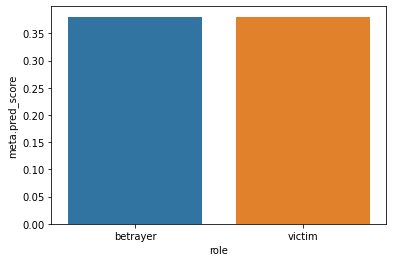

In [30]:
sns.barplot(data=compl_data, x = 'role', y = 'meta.pred_score')

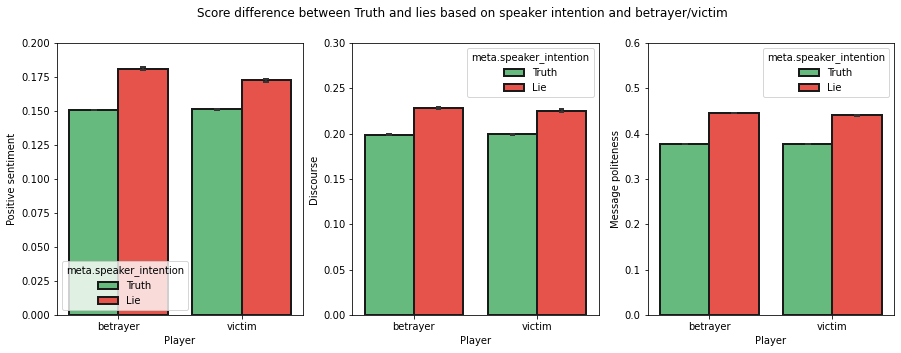

In [54]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
colors = {'Lie' : coolors["Red"], 'Truth': coolors["Emerald"]}
sns.barplot(y="sentiment_score",x = "role",hue = "meta.speaker_intention",data = compl_data,ax = axs[0],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
axs[0].set(ylim = (0,0.2),xlabel='Player',ylabel= 'Positive sentiment')
sns.barplot(y="discourse_score",x = "role",data = compl_data,hue = "meta.speaker_intention",ax = axs[1],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
axs[1].set(ylim = (0,0.3),xlabel='Player',ylabel= 'Discourse')
sns.barplot(y="meta.pred_score",x = "role",data = compl_data, hue = "meta.speaker_intention",ax = axs[2],ci = 68,capsize = 0.03,
            linewidth=2, errwidth = 2,errcolor=".2", edgecolor=".1", palette = colors)
axs[2].set(ylim = (0,0.6),xlabel='Player',ylabel= 'Message politeness')
plt.suptitle("Score difference between Truth and lies based on speaker intention and betrayer/victim")
plt.savefig('Long.png')
plt.show()

<AxesSubplot:xlabel='sentiment_score', ylabel='Count'>

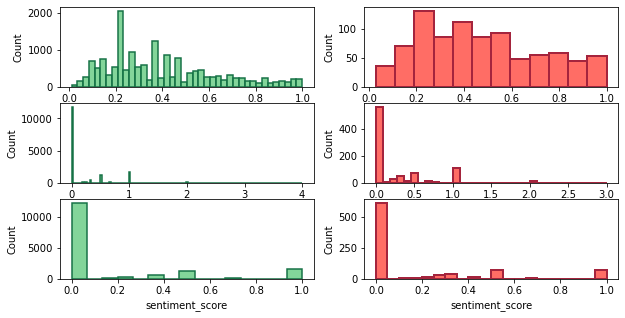

In [37]:
colors = {'Lie' : coolors["Red"], 'Truth': coolors["Emerald"]}
fig, axs = plt.subplots(3,2, figsize = (10,5))
sns.histplot(data = truths, x = "meta.pred_score", ax = axs[0,0], color = colors['Truth'], 
             edgecolor=coolors['Green'], linewidth=1.5)
sns.histplot(data = lies, x = "meta.pred_score", ax = axs[0,1], color=colors['Lie'], 
             edgecolor = coolors['Burgundy'], linewidth=2)
sns.histplot(data = truths, x = "discourse_score", ax = axs[1,0], color = colors['Truth'], 
             edgecolor=coolors['Green'], linewidth=1.5)
sns.histplot(data = lies, x = "discourse_score", ax = axs[1,1], color=colors['Lie'], 
             edgecolor = coolors['Burgundy'], linewidth=2)
sns.histplot(data = truths, x = "sentiment_score", ax = axs[2,0], color = colors['Truth'], 
             edgecolor=coolors['Green'], linewidth=1.5)
sns.histplot(data = lies, x = "sentiment_score", ax = axs[2,1], color=colors['Lie'], 
             edgecolor = coolors['Burgundy'], linewidth=2)

<AxesSubplot:xlabel='meta.speaker_intention', ylabel='discourse_number'>

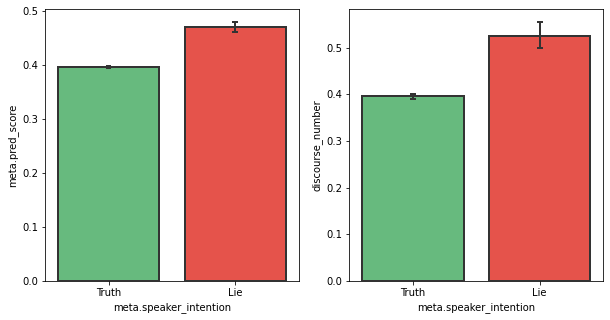

In [38]:
fig, axs = plt.subplots(1,2, figsize = (10,5))
sns.barplot(data = data, y = "meta.pred_score", x = "meta.speaker_intention", ci = 68, 
            capsize = 0.03, linewidth=2,errwidth = 2,errcolor=".2", edgecolor=".2", palette = colors, ax = axs[0])
sns.barplot(data = data, y = "discourse_number", x = "meta.speaker_intention", ci = 68, 
            capsize = 0.03, linewidth=2,errwidth = 2,errcolor=".2", edgecolor=".2", palette = colors, ax = axs[1])

to do :
- replotter les 3 figures du paper (Fig3 a, b, c)
- matching avec les relations de l'ancien dataset
